# Topic Modeling with CorEx

Activity for final CorEx topic model, as well as some additional pre-processing. 

Additional versions of previous models can be found in the CorEx Scratch Notebook, including:

* Specified Topics, but with **weak** strength
* Specified Topics, but with **strong** strength
* **Benefits** as the sole anchor word to identify specific programs

EDA found within this notebook is focused on ngrams analysis to help inform selected topics.

In [381]:
import pickle

In [2]:
import re

In [3]:
import string

In [65]:
import plotly.express as px

In [4]:
# Install CorEx 
# !pip install corextopic
# !pip install networkx

In [5]:
# Import other packages for examples
import pandas as pd
import numpy as np
import scipy.sparse as ss

from sklearn.feature_extraction.text import CountVectorizer
from sklearn import datasets

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
from sklearn.metrics import pairwise_distances

In [7]:
# Make better use of Jupyter Notebook cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

pd.set_option('display.max_rows', 660)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:,.10f}'.format

## Load the data

In [11]:
# df_zipped_post4_2019_sept_up_pickle = pickle.load(open("df_zipped_post4_2019_sept_up_2020-03-14_16PM.p", "rb"))

# df_zipped_post4_2019_sept_up_pickle.shape

In [10]:
combined_df_copy_pickle = pickle.load(open("combined_df_copy_2020-03-22_20PM.p", "rb"))

combined_df_copy_pickle.shape

(8856, 15)

## Pre-process the data

In [12]:
df_zipped_post = combined_df_copy_pickle.copy()

In [13]:
df_zipped_post.shape

(8856, 15)

In [14]:
df_zipped_post.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8856 entries, post_content1418166 to post_content1512119
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   post_text                   8856 non-null   object        
 1   post_time                   8856 non-null   object        
 2   post_author                 8856 non-null   object        
 3   original_post_id_container  8856 non-null   object        
 4   topic_title                 8856 non-null   object        
 5   post_hour_min               8856 non-null   object        
 6   post_date                   8856 non-null   datetime64[ns]
 7   dow                         8856 non-null   int64         
 8   week                        8856 non-null   period[W-SUN] 
 9   week_alt                    8856 non-null   object        
 10  month                       8856 non-null   object        
 11  year2                       

In [380]:
df_zipped_post.head(1)

,post_text,post_time,post_author,original_post_id_container,topic_title,post_hour_min,post_date,dow,week,week_alt,month,year2,Topic_Count,Topic_Name_or_Other,combined_time,post_text_original
post_id_container,,,,,,,,,,,,,,,,
post_content1418166,cue please explain,"12:27 PM - Sep 02, 2019","[""POST_AUTHOR"", ""teamgatorupdates""]",post_content1511221,Legacy Appeals; Actual number of days from Appeal Certification,12:27:00,2019-09-02,0,2019-09-02/2019-09-08,2019-w36,2019-09,2019,306,Legacy Appeals; Actual number of days from Appeal Certification,2019-09-02 12:27:00,CUE? Please explain


## Make Adjustments to text

In [46]:
# Create text copy
df_zipped_post['post_text_original'] = df_zipped_post['post_text']

#### Testing

In [49]:
new_df = df_zipped_post.loc[:,['post_id_container','post_time','topic_title','post_text','post_text_original']].head(10)

In [50]:
new_df.shape

(10, 5)

#### Removing Responses

In [132]:
def remove_original_responses(df):
    df.post_text = df["post_text"].str.split('\n\n\n').str[-1]
    df.post_text = df["post_text"].str.replace('\n\n', ' ', regex=False)
    df.post_text = df["post_text"].str.replace('\n', ' ', regex=False)
    df.post_text = df["post_text"].str.replace('...', '. ', regex=False)

#### Remove Specific Characters & Websites

In [18]:
no_at_symbol = lambda x: re.sub(r"@", ' ', x)
no_lb_symbol = lambda x: re.sub(r"#", ' ', x)
no_website = lambda x: re.sub(r"http\S+", '', x)

#### Remove Tapatalk References

In [19]:
tapatalk = lambda x: re.sub('sent.*tapatalk','',x, flags=re.DOTALL)

#### Remove Remaining Non-Alphanumeric and Standardize

In [20]:
alphanumeric = lambda x: re.sub('\w*\d\w*', '', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x.lower())

#### Replace Named Groups

In [21]:
ssa_word_list = ['social security', 'socialsecurity']
ssa_word_list2 = [' ss ',' ssa ']
vba_word_list = ['vavetbenefits','veterans benefits administration', 
                 'veteranbenefitsadministration']
vba_word_list2 = [' vba ']
vha_word_list = ['veteranshealth','veterans health administration']
vha_word_list2 = [' vha ']
veteran_word_list = ['i am a veteran','iamaveteran', 'i am a vet','im a vet']
va_word_list = ['deptvetaffairs']
va_word_list2 = ['the va ']
bva_word_list = ['bva', 'board of veterans appeals', 'board of veteran appeals',"board of veterans' appeals"]
black_veterans = ['black veterans','black veteran','black vets','blackvets','blackveterans']
covid_list = ['covidpandemic','covid pandemic','covid','coronavirus','covid19','covid-19','covid 19','the pandemic','this pandemic', 'coronaviruspandemic', 'coronavirus pandemic']
vaccine_list = ['coronavirus_pandemicvaccine','covid19vaccine','covidvaccine','covid19 vaccine','covid-19 vaccine','covid19vaccination','covid vaccine','covid19 vaccine',
          'covid-19 vaccines','coronavirus_pandemic vaccine','coronavaccine', 'the vaccine']
greetings_list = ['good morning', 'good evening', 'greetings all']


In [22]:
SSA = lambda x: re.sub("|".join(sorted(ssa_word_list, key = len, reverse = True)), 
                       'Social_Security', x)

In [23]:
SSA2 = lambda x: re.sub("|".join(sorted(ssa_word_list2, key = len, reverse = True)), 
                       ' Social_Security ', x)

In [24]:
VBA = lambda x: re.sub("|".join(sorted(vba_word_list, key = len, reverse = True)), 
                       'Veterans_Benefits_Admin', x)

In [25]:
VBA2 = lambda x: re.sub("|".join(sorted(vba_word_list2, key = len, reverse = True)), 
                       ' Veterans_Benefits_Admin ', x)

In [26]:
VHA = lambda x: re.sub("|".join(sorted(vha_word_list, key = len, reverse = True)), 
                       'Veterans_Health_Admin', x)

In [27]:
VHA2 = lambda x: re.sub("|".join(sorted(vha_word_list2, key = len, reverse = True)), 
                       ' Veterans_Health_Admin ', x)

In [28]:
veteran_words = lambda x: re.sub("|".join(sorted(veteran_word_list, key = len, reverse = True)), 
                       'i_am_a_veteran', x)

In [29]:
va_words = lambda x: re.sub("|".join(sorted(va_word_list, key = len, reverse = True)), 
                       'department_of_va', x)

In [30]:
va_words2 = lambda x: re.sub("|".join(sorted(va_word_list2, key = len, reverse = True)), 
                       'department_of_va ', x)

In [31]:
bva_words = lambda x: re.sub("|".join(sorted(bva_word_list, key = len, reverse = True)), 
                       'board_veterans_appeals', x)

In [32]:
black_veterans_words = lambda x: re.sub("|".join(sorted(black_veterans, key = len, reverse = True)), 
                       'black_veterans', x)

In [33]:
covid_words = lambda x: re.sub("|".join(sorted(covid_list, key = len, reverse = True)), 
                       'coronaviruspandemic', x)

In [34]:
vaccine_words = lambda x: re.sub("|".join(sorted(vaccine_list, key = len, reverse = True)), 
                       'coronaviruspandemic vaccine', x)

In [35]:
greetings = lambda x: re.sub("|".join(sorted(greetings_list, key = len, reverse = True)), 
                       'good_morning_evening', x) 

In [36]:
dont = lambda x: re.sub("|".join(sorted(greetings_list, key = len, reverse = True)), 
                       'good_morning_evening', x)  

#### Remove Emojis

In [37]:
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

In [38]:
remove_emoji('patience🤦‍ Veterans_Benefitsssss_Admin 🙏depar🙏tment_of_va Veterans_Health_Admin')
#emoji("Hi, I am Emoji  😜")

'patience Veterans_Benefitsssss_Admin department_of_va Veterans_Health_Admin'

#### Create Checking Tool

In [39]:
def update_base_table_for_CorEx(df):
    
    # Pre-process data
    df.drop_duplicates(subset='post_text',inplace=True)
    
    # Create copy of original post
    df['post_text_original'] = df['post_text']
    
    # Remove responses
    df.post_text = df["post_text"].str.split('\n\n\n').str[-1]
    df.post_text = df["post_text"].str.replace('\n\n', ' ', regex=False)
    df.post_text = df["post_text"].str.replace('\n', ' ', regex=False)
    df.post_text = df["post_text"].str.replace('...', '. ', regex=False)
    df.post_text = df["post_text"].str.replace('\t', ' ', regex=False) 
    df.post_text = df["post_text"].str.replace('↑', ' ', regex=False)
    
    # Mirror Tweet adjustments
    df['post_text'] = df.post_text.map(no_at_symbol)    # replace with a ' ', vs the rest of the replaces which will replace with ''
    df['post_text'] = df.post_text.map(no_lb_symbol)    # replace with a ' ', vs the rest of the replaces which will replace with ''
    df['post_text'] = df.post_text.map(punc_lower)
    df['post_text'] = df.post_text.map(no_website)
    df['post_text'] = df.post_text.map(SSA).map(SSA2).map(VBA).map(VBA2).map(VHA).map(VHA2).map(veteran_words).map(va_words).map(va_words2)
    df['post_text'] = df.post_text.map(black_veterans_words)
    df['post_text'] = df.post_text.map(covid_words) 
    df['post_text'] = df.post_text.map(vaccine_words) 
    df['post_text'] = df.post_text.map(bva_words)
    df['post_text'] = df.post_text.map(greetings)
    df['post_text'] = df.post_text.map(alphanumeric)
    df['post_text'] = df.post_text.map(tapatalk)
    df['post_text'] = df.post_text.apply(remove_emoji)
    #df.post_text = df.post_text.map(no_rt_marker)        
    
    return df

## Check Final DF

In [243]:
list_of_elements = ['post_content1452399',   
'post_content1503177',   
'post_content1505696',   
'post_content1507547',   
'post_content1507915',   
'post_content1510979']  

In [264]:
#contain_values = df_zipped_post2[df_zipped_post2['post_text'].str.contains('wasgionce wrote')]
#print (contain_values)
#df_zipped_post2.loc[df_zipped_post2['post_id_container'].isin(list_of_elements)]

In [40]:
df_zipped_post2 = update_base_table_for_CorEx(df_zipped_post)

In [41]:
df_zipped_post2.shape

(7824, 16)

In [44]:
df_zipped_post2.head(5)

,post_text,post_time,post_author,original_post_id_container,topic_title,post_hour_min,post_date,dow,week,week_alt,month,year2,Topic_Count,Topic_Name_or_Other,combined_time,post_text_original
post_id_container,,,,,,,,,,,,,,,,
post_content1418166,cue please explain,"12:27 PM - Sep 02, 2019","[""POST_AUTHOR"", ""teamgatorupdates""]",post_content1511221,Legacy Appeals; Actual number of days from Appeal Certification,12:27:00,2019-09-02,0,2019-09-02/2019-09-08,2019-w36,2019-09,2019,306,Legacy Appeals; Actual number of days from Appeal Certification,2019-09-02 12:27:00,CUE? Please explain
post_content1418167,the original ptsd claim is on appeal the attorney is shocked it was never awarded back in once it receives a hearing the attorney stated it should be awarded at least,"12:34 PM - Sep 02, 2019","[""POST_AUTHOR"", ""teamgatorupdates""]",post_content1511221,Legacy Appeals; Actual number of days from Appeal Certification,12:34:00,2019-09-02,0,2019-09-02/2019-09-08,2019-w36,2019-09,2019,306,Legacy Appeals; Actual number of days from Appeal Certification,2019-09-02 12:34:00,"The original PTSD claim is on appeal. The attorney is shocked it was never awarded back in 2009. Once it receives a hearing, the attorney stated it should be awarded AT LEAST 70%!"
post_content1418168,if service connection is on appeal that is all the board_veterans_appeals can decide the board_veterans_appeals will not assign a percentage as that is not on appeal raters determine percentages if the board_veterans_appeals grants service connection it will go back to the regional office for any percentage to be assigned if this claim was denied in and reopened in that is the denial that is on appeal not the one,"12:44 PM - Sep 02, 2019","[""POST_AUTHOR"", ""EKco22""]",post_content1511221,Legacy Appeals; Actual number of days from Appeal Certification,12:44:00,2019-09-02,0,2019-09-02/2019-09-08,2019-w36,2019-09,2019,306,Legacy Appeals; Actual number of days from Appeal Certification,2019-09-02 12:44:00,"If service connection is on appeal, that is all the BVA can decide. The BVA will NOT assign a percentage as that is not on appeal. Raters determine percentages. If the BVA grants service connection, it will go back to the regional office for any percentage to be assigned. If this claim was denied in 2009 and reopened in 2014 that is the denial that is on appeal, not the 2009 one."
post_content1418686,went to see the lung specialist today he is a triple board certified md and has provided new evidence of accidental injury from left chest tube causing intercostal nerve damage resulting in chronic chest pain inability to take deep breaths at normal intervals he has ordered up a cat scan and whatever evidence is produced is going directly to the board as of right now no decision has been made on my appeal it is my hope that the board will find in my favor based on new evidence from today will update here if anything happens,"6:50 PM - Sep 04, 2019","[""POST_AUTHOR"", ""Indy_CV62_OS""]",post_content1511221,Legacy Appeals; Actual number of days from Appeal Certification,18:50:00,2019-09-04,2,2019-09-02/2019-09-08,2019-w36,2019-09,2019,306,Legacy Appeals; Actual number of days from Appeal Certification,2019-09-04 18:50:00,"Went to see the lung specialist today. he is a triple Board Certified MD and has provided new evidence of accidental injury from left chest tube, causing Intercostal Nerve Damage resulting in chronic chest pain, inability to take deep breaths at normal intervals. He has ordered up a CAT scan and whatever evidence is produced is going directly to the Board. As of right now, no decision has been made on my Appeal. It is my hope that the Board will find in my favor based on new evidence from today. Will update here if anything happens."
post_content1418699,did he review your military medical records and post service medical records,"7:43 PM - Sep 04, 2019","[""POST_AUTHOR"", ""EKco22""]",post_content1511221,Legacy Appeals; Actual number of days from Appeal C

### Vectorize

In [46]:
from sklearn.feature_extraction import text 

In [168]:
additional_stop_words = ['rt','vets','vet','veteran','veterans']
additional_stop_words2 = ['rt','vets','vet','veteran','veterans','Veterans_Benefits_Admin','veterans_benefits_admin', 'veterans_health_admin',
                          'Veterans_Health_Admin','department_of_va','veteransbenefitsadmin departmentofva', 
                          'veteransbenefitsadmin departmentofva veterans_health_adminadminadminadminadmin', 
                          'departmentofva veterans_health_adminadminadminadminadmin', 'veteransbenefitsadmin', 
                          'veterans_health_adminadminadminadminadmin', 'departmentofva','va','cnn', 'foxnews','msnbc','nbc','abc','fox', 'tapatalk',
                          'cruiser','year','ago','old','just','know','said','dont','don','t','did','like','think','told', 'sent', 'using', 'wrote', 'pm', 'feb', 'good_morning_evening']

stop_wordz = text.ENGLISH_STOP_WORDS.union(additional_stop_words)
stop_wordz2 = text.ENGLISH_STOP_WORDS.union(additional_stop_words2)

In [199]:
vectorizer = CountVectorizer(#max_features=20000,
                             stop_words=stop_wordz2, #token_pattern="\\b[a-z][a-z]+\\b",
                             binary=False)

In [200]:
vectorizer_ngram2 = CountVectorizer(#max_features=20000,
                             stop_words=stop_wordz2, ngram_range=(2,2), #token_pattern="\\b[a-z][a-z]+\\b",
                             binary=False)

In [201]:
doc_word = vectorizer.fit_transform(df_zipped_post3.post_text)
words = list(np.asarray(vectorizer.get_feature_names()))

In [202]:
doc_word_ngram2 = vectorizer_ngram2.fit_transform(df_zipped_post3.post_text)
words_ngram2 = list(np.asarray(vectorizer_ngram2.get_feature_names()))

### Conduct N Gram Analysis
...to identify potential corex topics

In [58]:
from collections import Counter
from nltk import word_tokenize 
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = stop_wordz2

# doc_1 = 'Convolutional Neural Networks are very similar to ordinary Neural Networks from the previous chapter'
# doc_2 = 'Convolutional Neural Networks take advantage of the fact that the input consists of images and they constrain the architecture in a more sensible way.'
# doc_3 = 'In particular, unlike a regular Neural Network, the layers of a ConvNet have neurons arranged in 3 dimensions: width, height, depth.'
docs = df_zipped_post2.post_text.tolist() 
docs = (' '.join(filter(None, docs))).lower()

tokens = word_tokenize(docs)
tokens = [t for t in tokens if t not in stop_words]
word_l = WordNetLemmatizer()
tokens = [word_l.lemmatize(t) for t in tokens if t.isalpha()]

bi_grams = list(ngrams(tokens, 2)) 
counter = Counter(bi_grams)
counter.most_common(5)

[(('service', 'connected'), 310),
 (('cp', 'exam'), 251),
 (('effective', 'date'), 212),
 (('service', 'connection'), 200),
 (('medical', 'record'), 178)]

In [59]:
counter.most_common(20)

[(('service', 'connected'), 310),
 (('cp', 'exam'), 251),
 (('effective', 'date'), 212),
 (('service', 'connection'), 200),
 (('medical', 'record'), 178),
 (('coronaviruspandemic', 'vaccine'), 171),
 (('mental', 'health'), 142),
 (('good', 'luck'), 134),
 (('active', 'duty'), 132),
 (('sleep', 'apnea'), 126),
 (('rating', 'decision'), 112),
 (('hearing', 'loss'), 110),
 (('decision', 'letter'), 108),
 (('aid', 'attendance'), 103),
 (('medical', 'evidence'), 101),
 (('supplemental', 'claim'), 98),
 (('gon', 'na'), 83),
 (('new', 'claim'), 79),
 (('caregiver', 'program'), 79),
 (('file', 'claim'), 76)]

In [122]:
df = pd.DataFrame.from_records(counter.most_common(20), columns=['bigram','count'])
df["bigram"] = df["bigram"].astype(str)
df["bigram_original"] = df["bigram"]

In [128]:
df

,bigram,count,bigram_original
0,service_connected,310,"('service', 'connected')"
1,cp_exam,251,"('cp', 'exam')"
2,effective_date,212,"('effective', 'date')"
3,service_connection,200,"('service', 'connection')"
4,medical_record,178,"('medical', 'record')"
5,coronaviruspandemic_vaccine,171,"('coronaviruspandemic', 'vaccine')"
6,mental_health,142,"('mental', 'health')"
7,good_luck,134,"('good', 'luck')"
8,active_duty,132,"('active', 'duty')"
9,sleep_apnea,126,"('sleep', 'apnea')"


In [124]:
df['bigram'] = df['bigram'].str.replace(r"[\"\']", '')

In [125]:
df['bigram'] = df['bigram'].str.replace(r"[\(\)]", '')

In [126]:
df['bigram'] = df['bigram'].str.replace(r"[' ']", '')

In [127]:
df['bigram'] = df['bigram'].str.replace(r"[,]", '_')

In [95]:
bigram_string = lambda x: re.sub("'(.*)'",'',x, flags=re.DOTALL)

In [96]:
df['bigram'] = df.bigram.map(bigram_string)

In [74]:
fig = px.bar(df, x='bigram', y='count', title='Counts of top bigrams', template='plotly_white', labels={'bigram': 'Bigram', 'count': 'Count'})
fig.show()

#### ...add in most frequent words

In [162]:
from collections import Counter
from nltk import word_tokenize 
from nltk.util import ngrams
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = stop_wordz2

# doc_1 = 'Convolutional Neural Networks are very similar to ordinary Neural Networks from the previous chapter'
# doc_2 = 'Convolutional Neural Networks take advantage of the fact that the input consists of images and they constrain the architecture in a more sensible way.'
# doc_3 = 'In particular, unlike a regular Neural Network, the layers of a ConvNet have neurons arranged in 3 dimensions: width, height, depth.'
docs = df_zipped_post2.post_text.tolist() 
docs = (' '.join(filter(None, docs))).lower()

tokens = word_tokenize(docs)
tokens = [t for t in tokens if t not in stop_words]
word_l = WordNetLemmatizer()
tokens = [word_l.lemmatize(t) for t in tokens if t.isalpha()]

single_grams = list(ngrams(tokens, 1)) 
counter_single = Counter(single_grams)
counter_single.most_common(5)

[(('claim',), 1948),
 (('time',), 1669),
 (('day',), 1635),
 (('year',), 1070),
 (('im',), 974)]

In [163]:
counter_single

Counter({('cue',): 162,
         ('explain',): 88,
         ('original',): 174,
         ('ptsd',): 338,
         ('claim',): 1948,
         ('appeal',): 786,
         ('attorney',): 149,
         ('shocked',): 15,
         ('awarded',): 131,
         ('receives',): 11,
         ('hearing',): 335,
         ('stated',): 232,
         ('decide',): 66,
         ('assign',): 22,
         ('percentage',): 114,
         ('raters',): 93,
         ('determine',): 71,
         ('grant',): 168,
         ('regional',): 100,
         ('office',): 258,
         ('assigned',): 132,
         ('denied',): 381,
         ('reopened',): 17,
         ('denial',): 215,
         ('went',): 436,
         ('lung',): 51,
         ('specialist',): 69,
         ('today',): 489,
         ('triple',): 12,
         ('board',): 278,
         ('certified',): 36,
         ('md',): 8,
         ('provided',): 122,
         ('new',): 750,
         ('evidence',): 551,
         ('accidental',): 3,
         ('injury',): 146

### Make Bigrams into New Terms

In [87]:
df2 = df.copy()

In [138]:
df.bigram

0               service_connected
1                         cp_exam
2                  effective_date
3              service_connection
4                  medical_record
5     coronaviruspandemic_vaccine
6                   mental_health
7                       good_luck
8                     active_duty
9                     sleep_apnea
10                rating_decision
11                   hearing_loss
12                decision_letter
13                 aid_attendance
14               medical_evidence
15             supplemental_claim
16                         gon_na
17                      new_claim
18              caregiver_program
19                     file_claim
Name: bigram, dtype: object

In [130]:
df['bigram_original'] = df['bigram_original'].str.replace(r"[\(]", '[')

In [131]:
df['bigram_original'] = df['bigram_original'].str.replace(r"[\)]", ']')

In [140]:
service_connected_w = ['service connected']
cp_exam_w = ['cp exam']
effective_date_w = ['effective date']
service_connection_w = ['service connection']
medical_record_w = ['medical record']
covid_w2 = ['coronaviruspandemic vaccine']
mental_health_w = ['mental health']
good_luck_w = ['good luck']
active_duty_w = ['active duty']
sleep_apnea_w = ['sleep apnea']
rating_decision_w = ['rating decision']
hearing_loss_w = ['hearing loss']
decision_letter_w = ['decision letter']
aid_attend_w = ['aid attendance']
medical_evidence_w = ['medical evidence']
supp_claim_w = ['supplemental claim']
gon_na_w = ['gon na']
new_claim_w = ['new claim']
caregiver_w = ['caregiver program']
file_claim_w = ['file claim']

In [145]:

service_connected = lambda x: re.sub("|".join(sorted(service_connected_w, key = len, reverse = True)), 
                       'service_connected', x)
cp_exam = lambda x: re.sub("|".join(sorted(cp_exam_w, key = len, reverse = True)), 
                       'cp_exam', x)
effective_date = lambda x: re.sub("|".join(sorted(effective_date_w, key = len, reverse = True)), 
                       'effective_date', x)
service_connection = lambda x: re.sub("|".join(sorted(service_connection_w, key = len, reverse = True)), 
                       'service_connection', x)
medical_record = lambda x: re.sub("|".join(sorted(medical_record_w, key = len, reverse = True)), 
                       'medical_record', x)
covid2 = lambda x: re.sub("|".join(sorted(covid_w2, key = len, reverse = True)), 
                       'coronaviruspandemic_vaccine', x)
mental_health = lambda x: re.sub("|".join(sorted(mental_health_w, key = len, reverse = True)), 
                       'mental_health', x)
good_luck = lambda x: re.sub("|".join(sorted(good_luck_w, key = len, reverse = True)), 
                       'good_luck', x)
active_duty = lambda x: re.sub("|".join(sorted(active_duty_w, key = len, reverse = True)), 
                       'active_duty', x)
sleep_apnea = lambda x: re.sub("|".join(sorted(sleep_apnea_w, key = len, reverse = True)), 
                       'sleep_apnea', x)
rating_decision = lambda x: re.sub("|".join(sorted(rating_decision_w, key = len, reverse = True)), 
                       'rating_decision', x)
hearing_loss = lambda x: re.sub("|".join(sorted(hearing_loss_w, key = len, reverse = True)), 
                       'hearing_loss', x)
decision_letter = lambda x: re.sub("|".join(sorted(decision_letter_w, key = len, reverse = True)), 
                       'decision_letter', x)
aid_attend = lambda x: re.sub("|".join(sorted(aid_attend_w, key = len, reverse = True)), 
                       'aid_attendance', x)
medical_evidence = lambda x: re.sub("|".join(sorted(medical_evidence_w, key = len, reverse = True)), 
                       'medical_evidence', x)
supp_claim = lambda x: re.sub("|".join(sorted(supp_claim_w, key = len, reverse = True)), 
                       'supplemental_claim', x)
gon_na = lambda x: re.sub("|".join(sorted(cp_exam_w, key = len, reverse = True)), 
                      'cp_exam', x)
new_claim = lambda x: re.sub("|".join(sorted(new_claim_w, key = len, reverse = True)), 
                       'new_claim', x)
caregiver = lambda x: re.sub("|".join(sorted(caregiver_w, key = len, reverse = True)), 
                       'caregiver_program', x)
file_claim = lambda x: re.sub("|".join(sorted(cp_exam_w, key = len, reverse = True)), 
                       'file_claim', x)

In [146]:
def update_base_table_for_CorEx_bigrams(df):
    
    # Mirror Tweet adjustments
    df['post_text'] = df.post_text.map(service_connected)
    df['post_text'] = df.post_text.map(cp_exam)
    df['post_text'] = df.post_text.map(effective_date)
    df['post_text'] = df.post_text.map(service_connection)
    df['post_text'] = df.post_text.map(medical_record) 
    df['post_text'] = df.post_text.map(covid2)
    df['post_text'] = df.post_text.map(mental_health)
    df['post_text'] = df.post_text.map(good_luck)
    df['post_text'] = df.post_text.map(active_duty)
    df['post_text'] = df.post_text.map(sleep_apnea)     
    df['post_text'] = df.post_text.map(rating_decision)
    df['post_text'] = df.post_text.map(hearing_loss)
    df['post_text'] = df.post_text.map(decision_letter)
    df['post_text'] = df.post_text.map(aid_attend)
    df['post_text'] = df.post_text.map(medical_evidence)     
    df['post_text'] = df.post_text.map(supp_claim)
    df['post_text'] = df.post_text.map(gon_na)
    df['post_text'] = df.post_text.map(new_claim)
    df['post_text'] = df.post_text.map(caregiver)
    df['post_text'] = df.post_text.map(file_claim)     
    
    return df

In [147]:
update_base_table_for_CorEx_bigrams(df_zipped_post2)

,post_text,post_time,post_author,original_post_id_container,topic_title,post_hour_min,post_date,dow,week,week_alt,month,year2,Topic_Count,Topic_Name_or_Other,combined_time,post_text_original
post_id_container,,,,,,,,,,,,,,,,
post_content1418166,cue please explain,"12:27 PM - Sep 02, 2019","[""POST_AUTHOR"", ""teamgatorupdates""]",post_content1511221,Legacy Appeals; Actual number of days from Appeal Certification,12:27:00,2019-09-02,0,2019-09-02/2019-09-08,2019-w36,2019-09,2019,306,Legacy Appeals; Actual number of days from Appeal Certification,2019-09-02 12:27:00,CUE? Please explain
post_content1418167,the original ptsd claim is on appeal the attorney is shocked it was never awarded back in once it receives a hearing the attorney stated it should be awarded at least,"12:34 PM - Sep 02, 2019","[""POST_AUTHOR"", ""teamgatorupdates""]",post_content1511221,Legacy Appeals; Actual number of days from Appeal Certification,12:34:00,2019-09-02,0,2019-09-02/2019-09-08,2019-w36,2019-09,2019,306,Legacy Appeals; Actual number of days from Appeal Certification,2019-09-02 12:34:00,"The original PTSD claim is on appeal. The attorney is shocked it was never awarded back in 2009. Once it receives a hearing, the attorney stated it should be awarded AT LEAST 70%!"
post_content1418168,if service_connection is on appeal that is all the board_veterans_appeals can decide the board_veterans_appeals will not assign a percentage as that is not on appeal raters determine percentages if the board_veterans_appeals grants service_connection it will go back to the regional office for any percentage to be assigned if this claim was denied in and reopened in that is the denial that is on appeal not the one,"12:44 PM - Sep 02, 2019","[""POST_AUTHOR"", ""EKco22""]",post_content1511221,Legacy Appeals; Actual number of days from Appeal Certification,12:44:00,2019-09-02,0,2019-09-02/2019-09-08,2019-w36,2019-09,2019,306,Legacy Appeals; Actual number of days from Appeal Certification,2019-09-02 12:44:00,"If service connection is on appeal, that is all the BVA can decide. The BVA will NOT assign a percentage as that is not on appeal. Raters determine percentages. If the BVA grants service connection, it will go back to the regional office for any percentage to be assigned. If this claim was denied in 2009 and reopened in 2014 that is the denial that is on appeal, not the 2009 one."
post_content1418686,went to see the lung specialist today he is a triple board certified md and has provided new evidence of accidental injury from left chest tube causing intercostal nerve damage resulting in chronic chest pain inability to take deep breaths at normal intervals he has ordered up a cat scan and whatever evidence is produced is going directly to the board as of right now no decision has been made on my appeal it is my hope that the board will find in my favor based on new evidence from today will update here if anything happens,"6:50 PM - Sep 04, 2019","[""POST_AUTHOR"", ""Indy_CV62_OS""]",post_content1511221,Legacy Appeals; Actual number of days from Appeal Certification,18:50:00,2019-09-04,2,2019-09-02/2019-09-08,2019-w36,2019-09,2019,306,Legacy Appeals; Actual number of days from Appeal Certification,2019-09-04 18:50:00,"Went to see the lung specialist today. he is a triple Board Certified MD and has provided new evidence of accidental injury from left chest tube, causing Intercostal Nerve Damage resulting in chronic chest pain, inability to take deep breaths at normal intervals. He has ordered up a CAT scan and whatever evidence is produced is going directly to the Board. As of right now, no decision has been made on my Appeal. It is my hope that the Board will find in my favor based on new evidence from today. Will update here if anything happens."
post_content1418699,did he review your military medical_records and post service medical_records,"7:43 PM - Sep 04, 2019","[""POST_AUTHOR"", ""EKco22""]",post_content1511221,Legacy Appeals; Actual number of days from Appeal C

In [149]:
df.bigram

0               service_connected
1                         cp_exam
2                  effective_date
3              service_connection
4                  medical_record
5     coronaviruspandemic_vaccine
6                   mental_health
7                       good_luck
8                     active_duty
9                     sleep_apnea
10                rating_decision
11                   hearing_loss
12                decision_letter
13                 aid_attendance
14               medical_evidence
15             supplemental_claim
16                         gon_na
17                      new_claim
18              caregiver_program
19                     file_claim
Name: bigram, dtype: object

In [150]:
list_bigrams = df.bigram.to_list()

In [151]:
list_bigrams

['service_connected',
 'cp_exam',
 'effective_date',
 'service_connection',
 'medical_record',
 'coronaviruspandemic_vaccine',
 'mental_health',
 'good_luck',
 'active_duty',
 'sleep_apnea',
 'rating_decision',
 'hearing_loss',
 'decision_letter',
 'aid_attendance',
 'medical_evidence',
 'supplemental_claim',
 'gon_na',
 'new_claim',
 'caregiver_program',
 'file_claim']

In [152]:
df_zipped_post3 = df_zipped_post2.copy()

In [153]:
def update_bigram_columns(df):
    df['service_connected'] = np.where(df['post_text'].str.contains('service_connected'),1,0)
    df['cp_exam'] = np.where(df['post_text'].str.contains('cp_exam'),1,0)
    df['effective_date'] = np.where(df['post_text'].str.contains('effective_date'),1,0)
    df['service_connection'] = np.where(df['post_text'].str.contains('service_connection'),1,0)
    df['medical_record'] = np.where(df['post_text'].str.contains('medical_record'),1,0)
    df['coronaviruspandemic_vaccine'] = np.where(df['post_text'].str.contains('coronaviruspandemic_vaccine'),1,0)
    df['mental_health'] = np.where(df['post_text'].str.contains('mental_health'),1,0)
    df['good_luck'] = np.where(df['post_text'].str.contains('good_luck'),1,0)
    df['active_duty'] = np.where(df['post_text'].str.contains('active_duty'),1,0)
    df['sleep_apnea'] = np.where(df['post_text'].str.contains('sleep_apnea'),1,0)
    df['rating_decision'] = np.where(df['post_text'].str.contains('rating_decision'),1,0)
    df['hearing_loss'] = np.where(df['post_text'].str.contains('hearing_loss'),1,0)
    df['decision_letter'] = np.where(df['post_text'].str.contains('decision_letter'),1,0)
    df['aid_attendance'] = np.where(df['post_text'].str.contains('aid_attendance'),1,0)
    df['medical_evidence'] = np.where(df['post_text'].str.contains('medical_evidence'),1,0)
    df['supplemental_claim'] = np.where(df['post_text'].str.contains('supplemental_claim'),1,0)
    df['new_claim'] = np.where(df['post_text'].str.contains('new_claim'),1,0)
    df['caregiver_program'] = np.where(df['post_text'].str.contains('caregiver_program'),1,0)
    df['file_claim'] = np.where(df['post_text'].str.contains('file_claim'),1,0)
    
    #df.post_text = df.post_text.map(no_rt_marker)  

In [160]:
df_zipped_post3['gon_na'] = np.where(df_zipped_post3['post_text'].str.contains('gon_na'),1,0)

In [154]:
update_bigram_columns(df_zipped_post3)

In [155]:
df_zipped_post3

,post_text,post_time,post_author,original_post_id_container,topic_title,post_hour_min,post_date,dow,week,week_alt,month,year2,Topic_Count,Topic_Name_or_Other,combined_time,post_text_original,service_connected,cp_exam,effective_date,service_connection,medical_record,coronaviruspandemic_vaccine,mental_health,good_luck,active_duty,sleep_apnea,rating_decision,hearing_loss,decision_letter,aid_attendance,medical_evidence,supplemental_claim,new_claim,caregiver_program,file_claim
post_id_container,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
post_content1418166,cue please explain,"12:27 PM - Sep 02, 2019","[""POST_AUTHOR"", ""teamgatorupdates""]",post_content1511221,Legacy Appeals; Actual number of days from Appeal Certification,12:27:00,2019-09-02,0,2019-09-02/2019-09-08,2019-w36,2019-09,2019,306,Legacy Appeals; Actual number of days from Appeal Certification,2019-09-02 12:27:00,CUE? Please explain,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
post_content1418167,the original ptsd claim is on appeal the attorney is shocked it was never awarded back in once it receives a hearing the attorney stated it should be awarded at least,"12:34 PM - Sep 02, 2019","[""POST_AUTHOR"", ""teamgatorupdates""]",post_content1511221,Legacy Appeals; Actual number of days from Appeal Certification,12:34:00,2019-09-02,0,2019-09-02/2019-09-08,2019-w36,2019-09,2019,306,Legacy Appeals; Actual number of days from Appeal Certification,2019-09-02 12:34:00,"The original PTSD claim is on appeal. The attorney is shocked it was never awarded back in 2009. Once it receives a hearing, the attorney stated it should be awarded AT LEAST 70%!",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
post_content1418168,if service_connection is on appeal that is all the board_veterans_appeals can decide the board_veterans_appeals will not assign a percentage as that is not on appeal raters determine percentages if the board_veterans_appeals grants service_connection it will go back to the regional office for any percentage to be assigned if this claim was denied in and reopened in that is the denial that is on appeal not the one,"12:44 PM - Sep 02, 2019","[""POST_AUTHOR"", ""EKco22""]",post_content1511221,Legacy Appeals; Actual number of days from Appeal Certification,12:44:00,2019-09-02,0,2019-09-02/2019-09-08,2019-w36,2019-09,2019,306,Legacy Appeals; Actual number of days from Appeal Certification,2019-09-02 12:44:00,"If service connection is on appeal, that is all the BVA can decide. The BVA will NOT assign a percentage as that is not on appeal. Raters determine percentages. If the BVA grants service connection, it will go back to the regional office for any percentage to be assigned. If this claim was denied in 2009 and reopened in 2014 that is the denial that is on appeal, not the 2009 one.",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
post_content1418686,went to see the lung specialist today he is a triple board certified md and has provided new evidence of accidental injury from left chest tube causing intercostal nerve damage resulting in chronic chest pain inability to take deep breaths at normal intervals he has ordered up a cat scan and whatever evidence is produced is going directly to the board as of right now no decision has been made on my appeal it is my hope that the board will find in my favor based on new evidence from today will update here if anything happens,"6:50 PM - Sep 04, 2019","[""POST_AUTHOR"", ""Indy_CV62_OS""]",post_content1511221,Legacy Appeals; Actual number of days from Appeal Certification,18:50:00,2019-09-04,2,2019-09-02/2019-09-08,2019-w36,2019-09,2019,306,Legacy Appeals; Actual number of days from Appeal Certification,2019-09-04 18:50:00,"Went to see the lung specialist today. he is a triple Board Certified MD and has provided new evidence of accidental injury from left chest tube, causing Intercostal Nerve Damage resulting in chronic chest pain, inability to take deep breaths at normal intervals. He has ordered up a CAT scan and whatever evidence is produced is going directly t

In [156]:
df_zipped_post3.describe()

,dow,Topic_Count,service_connected,cp_exam,effective_date,service_connection,medical_record,coronaviruspandemic_vaccine,mental_health,good_luck,active_duty,sleep_apnea,rating_decision,hearing_loss,decision_letter,aid_attendance,medical_evidence,supplemental_claim,new_claim,caregiver_program,file_claim
count,"7,824.0000000000","7,824.0000000000","7,824.0000000000","7,824.0000000000","7,824.0000000000","7,824.0000000000","7,824.0000000000","7,824.0000000000","7,824.0000000000","7,824.0000000000","7,824.0000000000","7,824.0000000000","7,824.0000000000","7,824.0000000000","7,824.0000000000","7,824.0000000000","7,824.0000000000","7,824.0000000000","7,824.0000000000","7,824.0000000000","7,824.0000000000"
mean,2.9483640082,103.2839979550,0.0300357873,0.0270961145,0.0184049080,0.0175102249,0.0178936605,0.0118865031,0.0129089980,0.0172546012,0.0125255624,0.0080521472,0.0112474438,0.0067740286,0.0106083845,0.0000000000,0.0108640082,0.0094580777,0.0080521472,0.0030674847,0.0000000000
std,1.9366530303,161.3381624999,0.1706966986,0.1623739046,0.1344190340,0.1311709422,0.1325734658,0.1083822655,0.1128892579,0.1302269079,0.1112216423,0.0893774645,0.1054626016,0.0820304895,0.1024557871,0.0000000000,0.1036694514,0.0967978308,0.0893774645,0.0553034005,0.0000000000
min,0.0000000000,1.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
25%,1.0000000000,12.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
50%,3.0000000000,31.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
75%,5.0000000000,97.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
max,6.0000000000,597.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,0.0000000000,1.0000000000,1.0000000000,1.0000000000,1.0000000000,0.0000000000


In [161]:
df_zipped_post3[list_bigrams].apply(pd.Series.value_counts)

,service_connected,cp_exam,effective_date,service_connection,medical_record,coronaviruspandemic_vaccine,mental_health,good_luck,active_duty,sleep_apnea,rating_decision,hearing_loss,decision_letter,aid_attendance,medical_evidence,supplemental_claim,gon_na,new_claim,caregiver_program,file_claim
0,7589,7612,7680,7687,7684,7731,7723,7689,7726,7761,7736,7771,7741,"7,824.0000000000",7739,7750,"7,824.0000000000",7761,7800,"7,824.0000000000"
1,235,212,144,137,140,93,101,135,98,63,88,53,83,nan,85,74,nan,63,24,nan


In [165]:
df_zipped_post3.shape

(7824, 36)

## CorEx Analysis

In [203]:
# n_hidden is the number of topics
# words is your list of words used in your corpus
# I recommend adding docs=df.data to make it easier to check which sentences are in each resulting topic
topic_model_standard = ct.Corex(n_hidden=10, words=words, seed=1)
topic_model_standard.fit(doc_word, words=words, docs=df_zipped_post3.post_text)

# Print all topics from the CorEx topic model
topics_standard = topic_model_standard.get_topics()
for n,topic in enumerate(topics_standard):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: claim,decision,rating,letter,evidence,disability,appeal,based,file,claims
1: years,going,people,make,way,want,thing,opinion,say,new
2: time,things,right,went,didnt,work,doctor,long,use,need
3: bone,implant,dentist,dental,implants,mouth,spent,canadian,city,half
4: service_connected,condition,diagnosis,exam,diagnosed,symptoms,treatment,disease,examiner,cp_exam
5: big,country,lived,road,stock,face,index,parkinsons,stationed,ii
6: got,shot,wife,home,coronaviruspandemic,shots,day,vaccine,week,coronaviruspandemic_vaccine
7: medical,service,help,post,health,daily,program,best,read,local
8: pay,money,cost,line,working,tax,paid,college,dollars,taken
9: morning,snow,cold,winter,power,beautiful,weather,night,degrees,water


In [205]:
# Let's check out topic : CorEx Standard
for i in list(range (10)):
    print("Topic Model: {}".format(i))
    print(topic_model_standard.get_top_docs(topic=i, n_docs=3))
    print('+++++++++++++++++++++++++++++++++++++++')
    print('+++++++++++++++++++++++++++++++++++++++')

Topic Model: 0
[(' wrote   pm  feb  cpo wroteuntil others come along who have first hand experience please see this official va site as it has all the information\xa0 you may have already been there just fyi support for caregivers  the program of comprehensive assistance for family caregivers  just got my denial call dont waste your time unless you cant dress or bath yourself or get out of bed i specifically drilled the support line on whether we should apply because i know aid and attendance is for severely physically limited veterans that are pretty much bed ridden and i didnt want to get our hopes up if caregiver was going to be the same i was told no of course not please pursue caregiver aid because of the mental and cognitive issues we discussed in detail so much for that advice they dont care that my vet has forgotten how to use kitchen appliances safely or to cook a meal because he would set house on fire by never checking on whats in the oven or on stove top nor that his parkin

In [206]:
topic_model_low_strength = ct.Corex(n_hidden=10, words=words,
                       max_iter=200, verbose=False, seed=1)

topic_model_low_strength.fit(doc_word, words=words, docs=df_zipped_post3.post_text, 
                anchors=[['coronaviruspandemic','vaccine'], 
                         ['disability', 'appeal','board_veterans_appeals'], 
                         ['mental_health','mental','health','ptsd'],
                        ['aid_attendance','aid','attendance', 'caregiver'],
                        #['orange','bluewater', 'bwn','navy'],
                        ['sleep_apnea','sleep','apnea']], anchor_strength=3)
                        #['caregiver','program','caregiver_program']],
                            

# Print all topics from the CorEx topic model
topics_low_strength = topic_model_low_strength.get_topics()
for n,topic in enumerate(topics_low_strength):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: coronaviruspandemic,vaccine,got,people,long,shot,went,doing,took,wife
1: disability,appeal,board_veterans_appeals,claim,decision,rating,evidence,letter,based,file
2: health,ptsd,mental_health,medical,years,mental,time,need,going,doctor
3: attendance,aid,caregiver,point,use,program,daily,pain,criteria,activities
4: sleep,sleep_apnea,used,navy,little,apnea,came,army,drive,caused
5: big,peace,coast,country,san,implant,lived,pretty,city,food
6: say,pay,days,month,called,given,line,doesnt,form,benefits
7: money,kids,man,college,end,school,world,insurance,paying,real
8: morning,snow,cold,winter,house,south,weather,power,rain,night
9: test,surgery,cancer,disease,considered,knee,severe,diabetes,dbq,agent


In [207]:
# Let's check out topic : CorEx Low-Strength
for i in list(range (10)):
    print("Topic Model: {}".format(i))
    print(topic_model_low_strength.get_top_docs(topic=i, n_docs=3))
    print('+++++++++++++++++++++++++++++++++++++++')
    print('+++++++++++++++++++++++++++++++++++++++')

Topic Model: 0
[('murphy showed up at mass one sunday and the priest almost fell down when he saw him hed never seen murphy in church in his life after mass the priest caught up with him and said\xa0murphy i am so glad ya decided to come to mass what made ya come   murphy said\xa0i got to be honest with ya father a while back i misplaced me hat and i really really love that hat i know that mcglynn had a hat just like mine and i knew he came to church every sunday i also knew that he had to take off his hat during mass and figured he would leave it in the back of the church so i was going to leave after communion and steal mcglynns hat the priest said\xa0well murphy i notice that ya didnt steal mcglynns hat what changed your mind murphy replied\xa0well after i heard your sermon on the  commandments i decided that i didnt need ta steal mcglynns hat after all with a tear in his eye the priest gave murphy a big smile and said\xa0after i talked about thou shalt not steal ya decided you woul

In [209]:
# Note, instead of using .predict(doc_word), you can also call topic_model.labels
predictions = pd.DataFrame(topic_model_low_strength.predict(doc_word), columns=['topic'+str(i) for i in range(10)])
predictions.head(5)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,False,False,False,False,False,False,False,False,False,False
1,False,True,False,False,False,False,False,False,False,False
2,False,True,False,False,False,False,False,False,False,False
3,False,True,False,True,True,False,True,True,False,False
4,False,False,False,False,False,False,False,False,False,False


In [211]:
predictions_nums = pd.DataFrame(topic_model_low_strength.p_y_given_x, columns=['topic'+str(i) for i in range(10)])
predictions_nums.head(5)

,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9
0,0.0000010000,0.0000182918,0.0000010000,0.0000107212,0.0000010000,0.0009352894,0.0042946123,0.0006264694,0.0005725559,0.0009371487
1,0.0000010000,0.9999990000,0.0467125687,0.0000107233,0.0000010000,0.0009349515,0.0006414428,0.0006829823,0.0005724352,0.0009454962
2,0.0000010000,0.9999990000,0.0000012643,0.0000107217,0.0000010000,0.0009351446,0.1764708204,0.0006314890,0.0005726281,0.0009539073
3,0.0017584155,0.9999990000,0.0000124580,0.9999990000,0.9999990000,0.0009394967,0.9999990000,0.9999990000,0.0006823247,0.0053202904
4,0.0000010000,0.0000958201,0.0000365771,0.0000108224,0.0000010000,0.0009353297,0.0005996073,0.0006265097,0.0005726270,0.0009576043


In [212]:
predictions_nums.shape

(7824, 10)

### Analyze Number of Topics

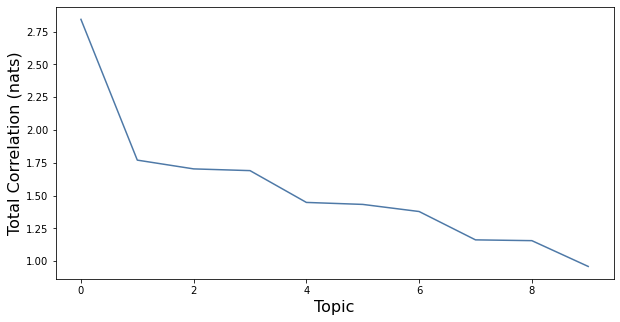

In [213]:
plt.figure(figsize=(10,5))
plt.plot(range(topic_model_standard.tcs.shape[0]), topic_model_standard.tcs, color='#4e79a7')#, width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

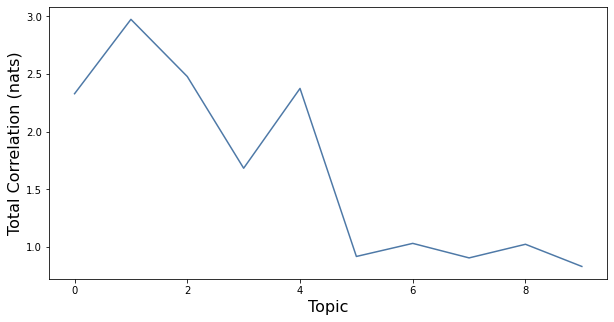

In [214]:
plt.figure(figsize=(10,5))
plt.plot(range(topic_model_low_strength.tcs.shape[0]), topic_model_low_strength.tcs, color='#4e79a7')#, width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

topic_model_low_strength

### Join Original Table with CorEx Analysis

In [215]:
df_zipped_post3 = df_zipped_post3.reset_index()

In [216]:
df_zipped_post3 = df_zipped_post3.join(pd.DataFrame(predictions_nums))

In [217]:
df_zipped_post3.shape

(7824, 47)

In [220]:
df_zipped_post3.head()

,post_id_container,post_text,post_time,post_author,original_post_id_container,topic_title,post_hour_min,post_date,dow,week,week_alt,month,year2,Topic_Count,Topic_Name_or_Other,combined_time,post_text_original,service_connected,cp_exam,effective_date,service_connection,medical_record,coronaviruspandemic_vaccine,mental_health,good_luck,active_duty,sleep_apnea,rating_decision,hearing_loss,decision_letter,aid_attendance,medical_evidence,supplemental_claim,new_claim,caregiver_program,file_claim,gon_na,Covid_Docs,Disability_and_Appeals_Docs,Mental_Health_Docs,Aid_and_Attendance_Docs,Sleep_Docs,City_Docs,Waiting_Docs,College_Kids_Docs,Cold_Weather_Docs,Cancer_and_Disease_Docs
0,post_content1418166,cue please explain,"12:27 PM - Sep 02, 2019","[""POST_AUTHOR"", ""teamgatorupdates""]",post_content1511221,Legacy Appeals; Actual number of days from Appeal Certification,12:27:00,2019-09-02,0,2019-09-02/2019-09-08,2019-w36,2019-09,2019,306,Legacy Appeals; Actual number of days from Appeal Certification,2019-09-02 12:27:00,CUE? Please explain,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000010000,0.0000182918,0.0000010000,0.0000107212,0.0000010000,0.0009352894,0.0042946123,0.0006264694,0.0005725559,0.0009371487
1,post_content1418167,the original ptsd claim is on appeal the attorney is shocked it was never awarded back in once it receives a hearing the attorney stated it should be awarded at least,"12:34 PM - Sep 02, 2019","[""POST_AUTHOR"", ""teamgatorupdates""]",post_content1511221,Legacy Appeals; Actual number of days from Appeal Certification,12:34:00,2019-09-02,0,2019-09-02/2019-09-08,2019-w36,2019-09,2019,306,Legacy Appeals; Actual number of days from Appeal Certification,2019-09-02 12:34:00,"The original PTSD claim is on appeal. The attorney is shocked it was never awarded back in 2009. Once it receives a hearing, the attorney stated it should be awarded AT LEAST 70%!",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000010000,0.9999990000,0.0467125687,0.0000107233,0.0000010000,0.0009349515,0.0006414428,0.0006829823,0.0005724352,0.0009454962
2,post_content1418168,if service_connection is on appeal that is all the board_veterans_appeals can decide the board_veterans_appeals will not assign a percentage as that is not on appeal raters determine percentages if the board_veterans_appeals grants service_connection it will go back to the regional office for any percentage to be assigned if this claim was denied in and reopened in that is the denial that is on appeal not the one,"12:44 PM - Sep 02, 2019","[""POST_AUTHOR"", ""EKco22""]",post_content1511221,Legacy Appeals; Actual number of days from Appeal Certification,12:44:00,2019-09-02,0,2019-09-02/2019-09-08,2019-w36,2019-09,2019,306,Legacy Appeals; Actual number of days from Appeal Certification,2019-09-02 12:44:00,"If service connection is on appeal, that is all the BVA can decide. The BVA will NOT assign a percentage as that is not on appeal. Raters determine percentages. If the BVA grants service connection, it will go back to the regional office for any percentage to be assigned. If this claim was denied in 2009 and reopened in 2014 that is the denial that is on appeal, not the 2009 one.",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000010000,0.9999990000,0.0000012643,0.0000107217,0.0000010000,0.0009351446,0.1764708204,0.0006314890,0.0005726281,0.0009539073
3,post_content1418686,went to see the lung specialist today he is a triple board certified md and has provided new evidence of accidental injury from left chest tube causing intercostal nerve damage resulting in chronic chest pain inability to take deep breaths at normal intervals he has ordered up a cat scan and whatever evidence is produced is going directly to the board as of right now no decision has been made on my appeal it is my hope that the board will find in my favor based on new evidence from today will update here if anything happens,"6:50 PM - Sep 04, 2019","[""POST_AUTHOR"", ""Indy_CV62_OS""]",post_content1511221,Legacy Appeal

In [219]:
df_zipped_post3.rename(columns = {'topic0':'Covid_Docs', 
                                  'topic1':'Disability_and_Appeals_Docs',
                                  'topic2':'Mental_Health_Docs',
                                  'topic3':'Aid_and_Attendance_Docs',
                                  'topic4':'Sleep_Docs', 
                                  'topic5':'City_Docs',
                                  'topic6':'Waiting_Docs', 
                                  'topic7':'College_Kids_Docs',
                                  'topic8':'Cold_Weather_Docs', 
                                  'topic9':'Cancer_and_Disease_Docs'}, inplace = True)

In [9]:
doc_topic

array([[3.63514186, 0.        ],
       [0.57097193, 0.28801878],
       [0.16826799, 0.03850893],
       [0.02951605, 0.24092715],
       [0.04867671, 0.34995818],
       [0.        , 4.38803093]])

array([0, 0, 0, 1, 1, 1])

In [224]:
doc_topic = topic_model_low_strength.p_y_given_x

In [225]:
doc_topic.argmax(axis=1)

array([6, 1, 1, ..., 1, 6, 8])

In [236]:
df_zipped_post3['top_topic'] = doc_topic.argmax(axis=1)

In [237]:
df_zipped_post3

,post_id_container,post_text,post_time,post_author,original_post_id_container,topic_title,post_hour_min,post_date,dow,week,week_alt,month,year2,Topic_Count,Topic_Name_or_Other,combined_time,post_text_original,service_connected,cp_exam,effective_date,service_connection,medical_record,coronaviruspandemic_vaccine,mental_health,good_luck,active_duty,sleep_apnea,rating_decision,hearing_loss,decision_letter,aid_attendance,medical_evidence,supplemental_claim,new_claim,caregiver_program,file_claim,gon_na,Covid_Docs,Disability_and_Appeals_Docs,Mental_Health_Docs,Aid_and_Attendance_Docs,Sleep_Docs,City_Docs,Waiting_Docs,College_Kids_Docs,Cold_Weather_Docs,Cancer_and_Disease_Docs,top_topic,Top Topic
0,post_content1418166,cue please explain,"12:27 PM - Sep 02, 2019","[""POST_AUTHOR"", ""teamgatorupdates""]",post_content1511221,Legacy Appeals; Actual number of days from Appeal Certification,12:27:00,2019-09-02,0,2019-09-02/2019-09-08,2019-w36,2019-09,2019,306,Legacy Appeals; Actual number of days from Appeal Certification,2019-09-02 12:27:00,CUE? Please explain,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000010000,0.0000182918,0.0000010000,0.0000107212,0.0000010000,0.0009352894,0.0042946123,0.0006264694,0.0005725559,0.0009371487,6,Waiting and Wait Times
1,post_content1418167,the original ptsd claim is on appeal the attorney is shocked it was never awarded back in once it receives a hearing the attorney stated it should be awarded at least,"12:34 PM - Sep 02, 2019","[""POST_AUTHOR"", ""teamgatorupdates""]",post_content1511221,Legacy Appeals; Actual number of days from Appeal Certification,12:34:00,2019-09-02,0,2019-09-02/2019-09-08,2019-w36,2019-09,2019,306,Legacy Appeals; Actual number of days from Appeal Certification,2019-09-02 12:34:00,"The original PTSD claim is on appeal. The attorney is shocked it was never awarded back in 2009. Once it receives a hearing, the attorney stated it should be awarded AT LEAST 70%!",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000010000,0.9999990000,0.0467125687,0.0000107233,0.0000010000,0.0009349515,0.0006414428,0.0006829823,0.0005724352,0.0009454962,1,Disability and Appeals
2,post_content1418168,if service_connection is on appeal that is all the board_veterans_appeals can decide the board_veterans_appeals will not assign a percentage as that is not on appeal raters determine percentages if the board_veterans_appeals grants service_connection it will go back to the regional office for any percentage to be assigned if this claim was denied in and reopened in that is the denial that is on appeal not the one,"12:44 PM - Sep 02, 2019","[""POST_AUTHOR"", ""EKco22""]",post_content1511221,Legacy Appeals; Actual number of days from Appeal Certification,12:44:00,2019-09-02,0,2019-09-02/2019-09-08,2019-w36,2019-09,2019,306,Legacy Appeals; Actual number of days from Appeal Certification,2019-09-02 12:44:00,"If service connection is on appeal, that is all the BVA can decide. The BVA will NOT assign a percentage as that is not on appeal. Raters determine percentages. If the BVA grants service connection, it will go back to the regional office for any percentage to be assigned. If this claim was denied in 2009 and reopened in 2014 that is the denial that is on appeal, not the 2009 one.",0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000010000,0.9999990000,0.0000012643,0.0000107217,0.0000010000,0.0009351446,0.1764708204,0.0006314890,0.0005726281,0.0009539073,1,Disability and Appeals
3,post_content1418686,went to see the lung specialist today he is a triple board certified md and has provided new evidence of accidental injury from left chest tube causing intercostal nerve damage resulting in chronic chest pain inability to take deep breaths at normal intervals he has ordered up a cat scan and whatever evidence is produced is going directly to the board as of right now no decision has been made on my appeal it is my hope that the board will find in my favor based on new evidence from today will update here if anything happens,"

In [241]:
equiv = {0:"Covid", 
         1:"Disability and Appeals", 
         2:"Mental Health",
         3:"Aid and Attendance",
         4:"Sleep", 
         5:"City Living", 
         6:"Waiting and Wait Times", 
         7:"College and Other Expenses",
         8:"Weather",
         9:"Cancer and Disease"}

In [242]:
df_zipped_post3["Top Topic"] = df_zipped_post3["top_topic"].map(equiv)

In [256]:
# to change default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.Set2.colors)

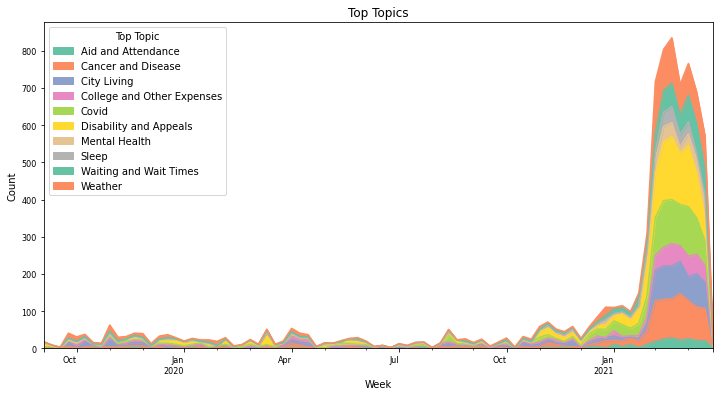

In [375]:
#combined_df_copy_first_post = pd.crosstab(combined_df_copy.week_alt, combined_df_copy.original_post)
ax = pd.crosstab(df_zipped_post3.week, df_zipped_post3["Top Topic"]).plot(figsize=(12,6), kind='area', stacked=True)

#ax = df.plot(kind='bar',x='name',y='age')
xticks = ax.xaxis.get_major_ticks()
for i,tick in enumerate(xticks):
    if i%10 != 0:
        tick.label1.set_visible(True)

plt.title('Top Topics')
plt.xlabel('Week')
plt.ylabel('Count')

plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
#fig.autofmt_xdate(rotation=45)
plt.xticks(rotation=0, ha='right')

plt.show()

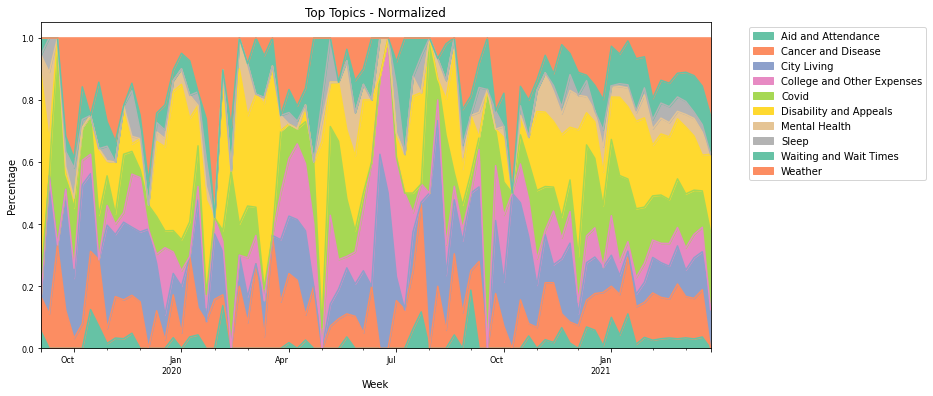

In [374]:
df_cross = pd.crosstab(df_zipped_post3.week, df_zipped_post3["Top Topic"])
ax = df_cross.div(df_cross.sum(1).astype(float), axis=0).plot(figsize=(12,6), kind='area', stacked=True)
#ax = df.plot(kind='bar',x='name',y='age')

xticks = ax.xaxis.get_major_ticks()
for i,tick in enumerate(xticks):
    if i%10 != 0:
        tick.label1.set_visible(True)

plt.title('Top Topics - Normalized')
plt.xlabel('Week')
plt.ylabel('Percentage')
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
#fig.autofmt_xdate(rotation=45)
plt.xticks(rotation=0, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.show()

#### ...make a graph highlighting covid

In [248]:
equiv2 = {0:"Covid", 
         1:"Other", 
         2:"Other",
         3:"Other",
         4:"Other", 
         5:"Other", 
         6:"Other", 
         7:"Other",
         8:"Other",
         9:"Other"}

In [ ]:
#cea2fd)

In [249]:
df_zipped_post3["Top Topic - Covid"] = df_zipped_post3["top_topic"].map(equiv2)

In [378]:
#combined_df_copy_first_post = pd.crosstab(combined_df_copy.week_alt, combined_df_copy.original_post)
pal = ["#d0f128", "#d8dcd6"]
pal = 
ax = pd.crosstab(df_zipped_post3.week, df_zipped_post3["Top Topic - Covid"]).plot(figsize=(12,6), 
                                                                                  kind='area', stacked=True, 
                                                                                  color = pal)

#ax = df.plot(kind='bar',x='name',y='age')
xticks = ax.xaxis.get_major_ticks()
for i,tick in enumerate(xticks):
    if i%10 != 0:
        tick.label1.set_visible(True)

plt.title('Top Topic - Covid')
plt.xlabel('Week')
plt.ylabel('Count')

plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
#fig.autofmt_xdate(rotation=45)
plt.xticks(rotation=0, ha='right')

plt.show()

SyntaxError: invalid syntax (<ipython-input-378-255f214f7a21>, line 3)

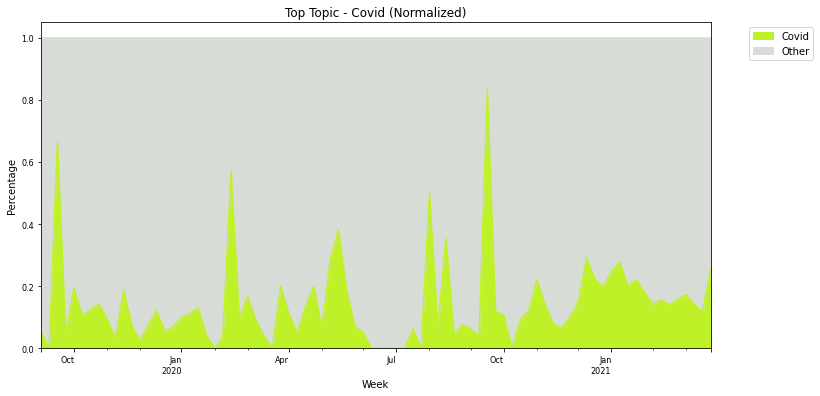

In [372]:
df_cross = pd.crosstab(df_zipped_post3.week, df_zipped_post3["Top Topic - Covid"])
ax = df_cross.div(df_cross.sum(1).astype(float), axis=0).plot(figsize=(12,6), kind='area', stacked=True, color = pal)
#ax = df.plot(kind='bar',x='name',y='age')

xticks = ax.xaxis.get_major_ticks()
for i,tick in enumerate(xticks):
    if i%10 != 0:
        tick.label1.set_visible(True)

plt.title('Top Topic - Covid (Normalized)')
plt.xlabel('Week')
plt.ylabel('Percentage')
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)
#fig.autofmt_xdate(rotation=90)
plt.xticks(rotation=0, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

plt.show()

### Pickle Latest

In [285]:
pickle.dump(df_zipped_post3, open("df_zipped_post3.p", "wb" ) )

### Predictor

In [286]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.decomposition import NMF
from sklearn.metrics import pairwise_distances

In [287]:
nmf_model = NMF(10)
doc_topic = nmf_model.fit_transform(doc_word)
doc_topic.shape

(7824, 10)

In [288]:
topic_word = nmf_model.components_
topic_word.shape

(10, 17977)

In [289]:
words = vectorizer.get_feature_names()
t = nmf_model.components_.argsort(axis=1)[:,-1:-7:-1]
topic_words = [[words[e] for e in l] for l in t]
topic_words

[['time', 'years', 'im', 'got', 'days', 'good'],
 ['right', 'disability', 'service_connected', 'static', 'pain', 'extremity'],
 ['appeal', 'board_veterans_appeals', 'decision', 'appeals', 'remand', 'case'],
 ['claim', 'file', 'claims', 'letter', 'filed', 'denied'],
 ['evidence', 'service', 'cue', 'diagnosis', 'denied', 'current'],
 ['decision', 'board', 'court', 'vetapp', 'appeal', 'smc'],
 ['use', 'nsaid', 'ckd', 'service', 'opinion', 'nsaids'],
 ['evaluation', 'percent', 'assigned', 'effective', 'cfr', 'impairment'],
 ['rating', 'disability', 'vso', 'rule', 'condition', 'based'],
 ['iu', 'exam', 'dbq', 'rater', 'examiner', 'based']]

In [293]:
doc_topic_nmf = pd.DataFrame(doc_topic.round(5),
                             #index = ex_label,
                             columns = ["component_1","component_2","component_3", 
                                        "component_4","component_5","component_6",
                                        "component_7","component_8","component_9",
                                        "component_10"])

doc_topic_nmf

,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10
0,0.0000000000,0.0000000000,0.0029100000,0.0000000000,0.0296800000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000
1,0.0000000000,0.0000000000,0.0674600000,0.1224700000,0.0000000000,0.0051600000,0.0000000000,0.0085100000,0.0005800000,0.0000000000
2,0.0000000000,0.0000000000,0.3251100000,0.0942000000,0.0018300000,0.0054400000,0.0000000000,0.0292100000,0.0000000000,0.0000000000
3,0.0120800000,0.0670300000,0.0859300000,0.0000000000,0.2077600000,0.1668100000,0.0000000000,0.0000000000,0.0000000000,0.0198100000
4,0.0000000000,0.0000000000,0.0005400000,0.0014300000,0.0649300000,0.0001500000,0.0304500000,0.0000000000,0.0000000000,0.0000000000
...,...,...,...,...,...,...,...,...,...,...
7819,0.0535500000,0.0000000000,0.0372700000,0.0353000000,0.0295300000,0.0000000000,0.0005900000,0.1506400000,0.0227500000,0.0262900000
7820,0.0015300000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0000000000,0.0002000000,0.0000000000
7821,0.1364800000,0.0196900000,0.0359900000,0.0227800000,0.0774600000,0.0000000000,0.0235800000,0.0351500000,0.1537100000,0.0239000000
7822,0.0276800000,0.0000000000,0.0033200000,0.0105500000,0.0000000000,0.0000000000,0.0012900000,0.0000000000,0.0000000000,0.0201400000


In [294]:
pairwise_distances(doc_topic[4].reshape(1,-1),doc_topic,metric='cosine')

array([[0.09840877, 0.97894235, 0.98242817, ..., 0.64822578, 0.9782489 ,
        0.99503823]])

In [296]:
pairwise_distances(doc_topic[4].reshape(1,-1),doc_topic,metric='cosine')

array([[0.09840877, 0.97894235, 0.98242817, ..., 0.64822578, 0.9782489 ,
        0.99503823]])

In [298]:
distance_measure = pairwise_distances(doc_topic[4].reshape(1,-1),doc_topic,metric='cosine').argsort()

In [304]:
post_ids = list(distance_measure[0][0:5])

In [305]:
similar_posts = df_zipped_post3.loc[post_ids]

In [306]:
similar_posts

,post_id_container,post_text,post_time,post_author,original_post_id_container,topic_title,post_hour_min,post_date,dow,week,week_alt,month,year2,Topic_Count,Topic_Name_or_Other,combined_time,post_text_original,service_connected,cp_exam,effective_date,service_connection,medical_record,coronaviruspandemic_vaccine,mental_health,good_luck,active_duty,sleep_apnea,rating_decision,hearing_loss,decision_letter,aid_attendance,medical_evidence,supplemental_claim,new_claim,caregiver_program,file_claim,gon_na,Covid_Docs,Disability_and_Appeals_Docs,Mental_Health_Docs,Aid_and_Attendance_Docs,Sleep_Docs,City_Docs,Waiting_Docs,College_Kids_Docs,Cold_Weather_Docs,Cancer_and_Disease_Docs,top_topic,Top Topic,Top Topic - Covid
4,post_content1418699,did he review your military medical_records and post service medical_records,"7:43 PM - Sep 04, 2019","[""POST_AUTHOR"", ""EKco22""]",post_content1511221,Legacy Appeals; Actual number of days from Appeal Certification,19:43:00,2019-09-04,2,2019-09-02/2019-09-08,2019-w36,2019-09,2019,306,Legacy Appeals; Actual number of days from Appeal Certification,2019-09-04 19:43:00,Did he review your military medical records and post service medical records?,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000010000,0.0000958201,0.0000365771,0.0000108224,0.0000010000,0.0009353297,0.0005996073,0.0006265097,0.0005726270,0.0009576043,9,Cancer and Disease,Other
2215,post_content1503310,do your service medical_records show treatment for athletes feet how long have you been out from active military service,"4:14 PM - Jan 14, 2021","[""POST_AUTHOR"", ""USMCgruntrvn""]",post_content1503149,VA Eval Form for Athlete's Foot,16:14:00,2021-01-14,3,2021-01-11/2021-01-17,2021-w2,2021-01,2021,6,Other,2021-01-14 16:14:00,Do your Service Medical Records show treatment for Athletes Feet? How long have you been out from active military service?,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000010000,0.0000041268,0.0000816745,0.0000108235,0.0000010000,0.0009254017,0.0051637921,0.0006290800,0.0005697683,0.0637882711,9,Cancer and Disease,Other
6558,post_content1510397,there are many things that can cause this it should be diagnosed before discarding the idea that it could be service related,"6:48 AM - Mar 08, 2021","[""POST_AUTHOR"", ""Charlie8d""]",post_content1510334,neuropathy of feet,06:48:00,2021-03-08,0,2021-03-08/2021-03-14,2021-w10,2021-03,2021,20,Other,2021-03-08 06:48:00,There are many things that can cause this & it should be diagnosed before discarding the idea that it could be service related.,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000010000,0.0000010000,0.0009729693,0.0000108355,0.0000010000,0.0009380784,0.0024098002,0.0000051086,0.0005725320,0.0074294817,9,Cancer and Disease,Other
6599,post_content1510455,i forgot to welcome you to the forum so welcome and thank you for your service,"2:09 PM - Mar 08, 2021","[""POST_AUTHOR"", ""JNoxon""]",post_content1510449,VA Disability rating prior to decision being made,14:09:00,2021-03-08,0,2021-03-08/2021-03-14,2021-w10,2021-03,2021,8,Other,2021-03-08 14:09:00,I forgot to welcome you to the forum! So welcome and thank you for your service!,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000010000,0.0000010000,0.0000010000,0.0000110822,0.0000010000,0.0009363238,0.0021889677,0.0006263334,0.0005724206,0.0102655947,9,Cancer and Disease,Other
5894,post_content1509556,there is no specific requirement that you have a dd however there must be some official verification of your service as brovet requested please provide some details on your service and your disabling conditions that you believe to be due to that service cruiser,"7:48 AM - Mar 02, 2021","[""POST_AUTHOR"", ""Cruiser""]",post_content1509524,Denial of VA claim,07:48:00,2021-03-02,1,2021-03-01/2021-03-07,2021-w9,2021-03,2021,11,Other,2021-03-02 07:48:00,"There is no specific requirement that you have a DD 214; however, there must be some official verification of your service. As BROVET requested, please provide some details on your service a

In [357]:
t = ['diabetes']

In [358]:
vt = vectorizer.transform(t)

In [359]:
tt = nmf_model.transform(vt)

In [360]:
pairwise_distances(tt,doc_topic,metric='cosine').argsort()

array([[5491, 1600, 1184, ..., 3661, 1051, 6983]])

In [361]:
pairwise_distances(tt.reshape(1,-1),doc_topic,metric='cosine').argsort()

array([[5491, 1600, 1184, ..., 3661, 1051, 6983]])

In [362]:
distance_measure = pairwise_distances(tt.reshape(1,-1),doc_topic,metric='cosine').argsort()

In [363]:
post_ids = list(distance_measure[0][0:20])

In [364]:
similar_posts = df_zipped_post3.loc[post_ids]

In [368]:
similar_posts[['topic_title','post_text_original']]

,topic_title,post_text_original
5491,Hypothryoidism and Agent Orange,"livelsberger wrote: 4:21 PM - Feb 21Years ago at least 35, I put in a claim for hypothyroidism caused by agent orange it was denied. Now since it is on the list do I file as a new claim or ask for a DRO review? Thanks Gents. My father in-law just got service connected for agent orange, but I don't see hypothyroidism on the list? I'm looking at this list. *Edited by EKco22 to remove law firm website*"
1600,Quesstions Re Filing Diabetes Clailm,I got message from my doctor and am diagnosed as a diabetic. I have to have an appointment with him to discuss mediation or trying to control things by diet and exercise. After we decide on a course of treatment I will file a claim.
1184,Chernobyl Illnesss From West Germany,"FarmerInTheDell wrote: Aug 21, 2020Hi Miguel, I lost the case. They said that Hypothyroidism is a common illness and not enough evidence to suggest Chernobyl. I disagree. I think it’s what triggered my hypothyroidism and my autoimmune disease! You could go on Google , and start with Chernobyl radiation poisoning cloud over Germany and start your search the Chernobyl Affects ,Chernobyl areas affected by radiation ,and Military vehicles and aircraft exhaust exposure, Chernobyl acciddent and its consequences, public health (fuels petroleum, oil,lubricant how the Chernobyl cloud affected cognitive abilities in Germany, a map of how far was your company from Chernobyl, a map of the border and your company ,Google the distance of the town to Chernobyl how many miles, Chernobyl Hypothyroidism , Chernobyl Autoimmune disease, Chernobyl radiation zone area the was affected , ▪︎▪︎the Chernobyl accident - an epidemiological perspective this the part the talks about THYRIOD CANCER FORM CHERNOBYL. and watch also YouTube on Chernobyl radiation. then re- file your claim and submit again. Do give up all on this website will give you a feed back .remember Chernobyl radius zone over Germany and chernobyl dates also all are important."
1012,Legacy Appeals; Actual number of days from Appeal Certification,"Just my $.02 I've been in the VA system for a decade. Had an incredibly complicated TBI claim. I've been a patient in the VA Poly Trauma unit for 8 years. Every one of my Dr's had notes detailing the tests, treatment, and diagnosis. These items were the basis of a successful claim. .eventually, from the VBA. I never had a Nexus letter written by one of my Dr's. I'm not exactly sure what additional value they would have provided when everything was in their notes. . .again. My $.02. ."
6650,Won tinnitus with no hearing loss,I filed for tinnitus and hearing loss back in 2011. I do have both conditions and it was documented with private medical records but never in my military health records since it didn’t appear until after active duty. I was an F-4 engine mechanic in the USMC in the late 60s and an Air Force recruiter in the 80s and 90s. The basis of my claim from the USMC was working flight line maintenance where there was never a quiet time. In Air Force recruiting we did numerous flight line displays where aircraft noise was very common. My claim was denied I believe for not being considered service connected and I accepted that. Maybe I should have taken it to the next level.
5673,Outside doc reports / visits,"Philly19721986 wrote: 9:33 AM - Feb 18As someone who works claims daily, I disagree with the comments that say just tell the VA which provider(s) have your records. Doing this is guaranteed to slow down the processing of your claim. The best thing to do is submit your private medical records when you file your claim. As Cruiser mentioned, only submit relevant treatment records. Don’t waste the time of VSRs and especially RVSRs with hundreds of pages of treatment records that aren’t relevant to your claim. Hey Philly, quick question. Cruiser also said not to leave gaps either. My record from my GP alone is 500 pages, most of which isn't relevant, so how do I su